In [3]:
import itertools
import math as m
import numpy as np
from scipy import special as s #special.erfi
import matplotlib.pyplot as plt
import cmath as c
import time
from numpy.core.umath_tests import inner1d
from scipy import optimize

ipykernel_launcher:8: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.


Here we define the Zeta function the same as the previous notebook

$$
Z^{\mathrm{d}}(x^2;\alpha) = \left[\,\sum_{\mathbf{n}\in\mathbb{Z}^3} - \int \! \mathrm{d}^3\mathbf{n} \, \right] \frac{\omega_{n1}^{\star}}{\omega_{n1}} \frac{1}{n^{\star\,2} - x^2} e^{-\alpha(n^{\star\,2} - x^2)}
$$


With the finite volume $F$ function being defined as

$$
F(E,\mathbf{P},L) = \frac{\xi}{8\pi^2 L E^{\star}} \lim_{\alpha \to 0} Z^{\mathrm{P}L/2\pi}\left( (q^{\star}L / 2\pi)^2 ;\alpha \right)
$$


Again, it is convenient to define this function in terms of dimensionless parameters
$$
\bar{E}^{\star} = \frac{E^{\star}L}{2\pi}
$$


$$
F(\bar{E},\mathbf{d},mL) = \frac{\xi}{16\pi^3 \bar{E}^{\star}} \lim_{\alpha \to 0} Z^{\mathrm{P}L/2\pi}\left( x^2 ;\alpha \right)
$$


$$
\mathcal{M}^{-1}(E^{\star}) + F(E,\mathbf{P};L) = 0
$$


$$
\mathcal{K}^{-1}(E^{\star}) + \mathrm{Re}\,F(E,\mathbf{P};L) = 0
$$


The L\"uscher quantization condition stems from poles of the finite-volume correlation function,
$$
\mathcal{M}_L(P) = \frac{1}{\mathcal{M}^{-1}(s) + F(E,\mathbf{P},L)}
$$

Or, where
$$
\mathrm{det}\!\left[ \, \mathcal{M}^{-1}(s) + F(E,\mathbf{P},L) \, \right] = 0
$$

In [65]:
'''
 sqrt with branch cut aligned on positive real axis
'''
def mySqrt( z ):
   return 1j * c.sqrt( -z )

'''
 inner product for two list (native)
'''
def dot(A, B):
   return np.dot(A,B) #inner1d(A,B) #np.sum( A * B, axis=1) 

'''
 Function to generate 3-tuple "n = (nx,ny,nz)" list 
 subject to the constraint nx^2 + ny^2 + nz^2 <= nShell^2,
 where "nShell" indicates the number of shells
'''
def generateIntList( nShell ):
    intList = []
    rawList = np.array(np.arange(-nShell,nShell+1))
    for i in itertools.product(rawList,rawList,rawList):
        tmpList = np.array(i)
        if ( np.dot(tmpList,tmpList) <= nShell*nShell ):
            intList.append(tmpList)

    return np.asarray(intList)

#n = [ [a1,a2,a3], [b1,b2,b3], [c1,c2,c3], ... ]

## inner1d(n,n) = [ a.dot(a), b.dot(b), ... ]

## n.dot(unit(beta)) = [ a.dot(unit(beta)), b.dot(unit(beta)), ... ]

'''
 returns the unit vector of a vector "A"
'''
def unit_vector( A ):
    if( all( A==0 ) ):
        return 0.0
    else:
        return A / np.sqrt( np.dot(A,A) )

'''
 special multiply for array of arrays (A) and an array (B), used in the zeta function
'''
def multiply( A, B ):
   nA = len(A)
   return A.reshape(nA,1) * np.tile( B, (nA,1) )
   ### First, reshape A array to 2d (1xnA), and then copy b vector nA time to make (nA x nB) array
   ### alternatively, do (A.reshape(nA,1)).dot( B.reshape(1,3) ) 
   ### bad alternative:  np.full( (nB,nA), A ).T * np.full( (nA,nB) , B )


'''
 returns a Lorentz boosted four vector "(A0,A)" given some boost
 velocity "beta"
'''
def lorentzBoost( A0, A, beta ):
    gamma = 1.0 / np.sqrt( 1.0 - np.dot(beta,beta) )
    Apar  = multiply( A.dot( unit_vector(beta) ), unit_vector(beta) )
    Aper  = A - Apar
    A0_prime = gamma * ( A0 - A.dot( beta ) )
    A_prime  = gamma * ( Apar - multiply( A0, beta ) ) + Aper
    return A0_prime, A_prime

'''
 KSS cutoff function
'''
def cutoff( x_sq, n_sq, alpha ):
    return np.exp( -alpha * ( n_sq - x_sq ) )

'''
 KSS Zeta function for ell = m_ell = 0, given "x_sq", total momentum "nP"
 This function is in units of L / 2pi, e.g. m1 -> m1 * L / (2 * pi).
'''
def zetaFunction( x_sq, nP, alpha ):
    Ecm = np.sqrt( m1_sq + x_sq ) + np.sqrt( m2_sq + x_sq )
    beta = nP / np.sqrt( Ecm * Ecm + np.dot(nP,nP) )    

    n = intList
    n0 = np.sqrt( m1_sq + inner1d(n,n) )
    n0_cm, n_cm = lorentzBoost( n0, n, beta )
    tmp = cutoff( x_sq, inner1d(n_cm,n_cm), alpha ) * n0_cm / n0 
    tmp = tmp / ( inner1d(n_cm,n_cm ) - x_sq ) 
    sum0 = np.sum( tmp )

    eps = 1.0e-16 * ( 1.0 - m.copysign(1, x_sq) )
    x   = c.sqrt( x_sq + 1j * eps )
    z   = c.sqrt( alpha * x_sq )
    integral = 4.0 * m.pi * ( ( m.sqrt( 0.25 * m.pi / alpha ) ) * m.exp( alpha * x_sq )
                              - 0.5 * m.pi * x * s.erfi( z ) )
        
    return sum0 - integral - 4.0 * m.pi * ( 0.5 * 1j * m.pi * x ) # last term needed to compare to BBHO







In [73]:
'''
 convert Ecm to x_sq 
'''
def x_sq( Ecm ):
    return ( Ecm * Ecm - ( m1 + m2 )**2 ) * ( Ecm * Ecm - ( m1 - m2 )**2 ) / ( 4.0 * Ecm * Ecm )


def finiteVolumeF( E, nP, ident, alpha ):
    xi = 1.0
    if ( ident == 'yes' ):
        xi = 0.5
    Ecm = np.sqrt( E**2 - np.dot(nP,nP) )
    pre_factor = xi / ( 16.0 * m.pi**2 * Ecm )
    return pre_factor * zetaFunction( x_sq( Ecm ), nP, alpha )

(-50, 50)

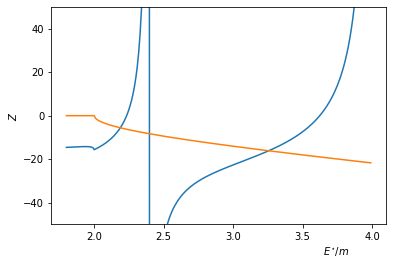

In [70]:
alpha = .1 #( 1.0 / 3.0 )**4
nShell = 2

intList = generateIntList( nShell )


m1 = 4.0 / ( 2.0 * np.pi )
m2 = 4.0 / ( 2.0 * np.pi )
nP = np.array([0,0,1])
m1_sq = m1**2
m2_sq = m2**2


Ecm_o_m_start = 1.8
Ecm_o_m_stop = 4.0
Ecm_o_m_step = 0.01

#print( zetaFunction( 0.1, nP, alpha ) )

Ecm_o_msq = np.arange(1.8, 4.0, 0.01)
zeta = []

#print(divide(nP ,Ecm_o_msq))
Ecm = Ecm_o_msq * m1
for Ecm in np.arange (Ecm_o_m_start, Ecm_o_m_stop, Ecm_o_m_step):
   Ecm = Ecm * m1
   zeta.append( zetaFunction( x_sq(Ecm), nP, alpha ) )

Zval = np.asarray(zeta)
plt.plot(Ecm_o_msq, Zval.real)
plt.plot(Ecm_o_msq, Zval.imag)
plt.xlabel(r'$E^{\star} / m$', position=(.85,1))
plt.ylabel(r'$Z$')
plt.ylim(-50, 50)


(-0.5, 0.5)

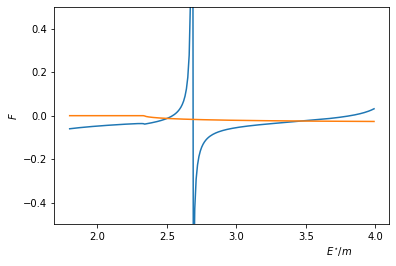

In [77]:
alpha = .1 #( 1.0 / 3.0 )**4
nShell = 2

intList = generateIntList( nShell )


m1 = 4.0 / ( 2.0 * np.pi )
m2 = 4.0 / ( 2.0 * np.pi )
nP = np.array([0,0,1])
m1_sq = m1**2
m2_sq = m2**2


Ecm_o_m_start = 1.8
Ecm_o_m_stop = 4.0
Ecm_o_m_step = 0.01

#print( zetaFunction( 0.1, nP, alpha ) )

Ecm_o_msq = np.arange(1.8, 4.0, 0.01)
F = []

ident = 'yes'

#print(divide(nP ,Ecm_o_msq))
Ecm = Ecm_o_msq * m1
for Ecm in np.arange (Ecm_o_m_start, Ecm_o_m_stop, Ecm_o_m_step):
    E = np.sqrt( Ecm * Ecm + np.dot(nP,nP) )
    E = E * m1
    F.append( finiteVolumeF( E, nP, ident, alpha ) )

Fval = np.asarray(F)
plt.plot(Ecm_o_msq, Fval.real)
plt.plot(Ecm_o_msq, Fval.imag)
plt.xlabel(r'$E^{\star} / m$', position=(.85,1))
plt.ylabel(r'$F$')
plt.ylim(-.5, .5)

In [ ]:
#### WIP!!!!!!!!### for vector version


'''
 returns the unit vector of a vector "A"
'''
def unit_vector( A ):
    if( A.all==0 ):
        return 0.0
    else:
        print(A)
        print("A.A",  np.dot(A,A,out=None) )
        return 1.0 #divide(A, np.sqrt( np.dot(A,A) ) )

'''
 special multiply for array of arrays (A) and an array (B), used in the zeta function
'''
def multiply( A, B ):
   nA = len(A)
   return A.reshape(nA,1) * np.tile( B, (nA,1) )
   ### First, reshape A array to 2d (1xnA), and then copy b vector nA time to make (nA x nB) array
   ### alternatively, do (A.reshape(nA,1)).dot( B.reshape(1,3) ) 
   ### bad alternative:  np.full( (nB,nA), A ).T * np.full( (nA,nB) , B )

def divide( A, B ):
   nA = len(A)
   return A.reshape(nA,1) / np.tile( B, (nA,1) )

'''
 returns a Lorentz boosted four vector "(A0,A)" given some boost
 velocity "beta"
'''
def lorentzBoost( A0, A, beta ):
    gamma = 1.0 / np.sqrt( 1.0 - inner1d(beta,beta) )
    Apar  = multiply( inner1d(A, unit_vector(beta) ), unit_vector(beta) )
    Aper  = A - Apar
    A0_prime = gamma * ( A0 - inner1d(A, beta ) )
    A_prime  = gamma * ( Apar - multiply( A0, beta ) ) + Aper
    return A0_prime, A_prime

'''
 KSS cutoff function
'''
def cutoff( x_sq, n_sq, alpha ):
    return np.exp( -alpha * ( n_sq - x_sq ) )

'''
 KSS Zeta function for ell = m_ell = 0, given "x_sq", total momentum "nP"
 This function is in units of L / 2pi, e.g. m1 -> m1 * L / (2 * pi).
'''
def zetaFunction( x_sq, nP, alpha ):
    Ecm = np.sqrt( m1_sq + x_sq ) + np.sqrt( m2_sq + x_sq )
    beta = divide( nP, np.sqrt( Ecm * Ecm + np.dot(nP,nP) ) )

    n = intList
    n0 = np.sqrt( m1_sq + inner1d(n,n) )
    n0_cm, n_cm = lorentzBoost( n0, n, beta )
    tmp = cutoff( x_sq, inner1d(n_cm,n_cm), alpha ) * n0_cm / n0 
    tmp = tmp / ( inner1d(n_cm,n_cm ) - x_sq ) 
    sum0 = np.sum( tmp )

    eps = 1.0e-16 * ( 1.0 - m.copysign(1, x_sq) )
    x   = c.sqrt( x_sq + 1j * eps )
    z   = c.sqrt( alpha * x_sq )
    integral = 4.0 * m.pi * ( ( m.sqrt( 0.25 * m.pi / alpha ) ) * m.exp( alpha * x_sq )
                              - 0.5 * m.pi * x * s.erfi( z ) )
        
    return sum0 - integral - 4.0 * m.pi * ( 0.5 * 1j * m.pi * x ) # last term needed to compare to BBHO








#print( zetaFunction( 0.1, nP, alpha ) )

Ecm_o_msq = np.arange(1.8, 4.0, 0.01)

#print(divide(nP ,Ecm_o_msq))
Ecm = Ecm_o_msq * m1
Zval = zetaFunction( x_sq(Ecm), nP, alpha )
plt.plot(Ecm_o_msq, Zval.real)
plt.plot(Ecm_o_msq, Zval.imag)
plt.xlabel(r'$E^{\star} / m$', position=(.85,1))
plt.ylabel(r'$Z$')